<a href="https://colab.research.google.com/github/pranathi0726/python-project/blob/main/pythonproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# Amazon Bestsellers: Multiclass Rank-Bucket Classification
# Robust, version-friendly code + clear reports
# ============================================================

import os
import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------
# 0) Path to your dataset
# -----------------------
# Edit this path if your file is elsewhere
DATA_PATH = "/mnt/data/extracted_data/Amazon_bestsellers_items_2025.csv"

if not os.path.exists(DATA_PATH):
    # Common fallbacks
    for p in [
        "./Amazon_bestsellers_items_2025.csv",
        "/mnt/data/Amazon_bestsellers_items_2025.csv"
    ]:
        if os.path.exists(p):
            DATA_PATH = p
            break

# -----------------------
# 1) Load + quick cleanup
# -----------------------
df = pd.read_csv(DATA_PATH)

# Parse price to numeric
def parse_price(x):
    if pd.isna(x):
        return np.nan
    x = re.sub(r"[^0-9.]", "", str(x))
    return float(x) if x else np.nan

df["price_num"] = df["product_price"].apply(parse_price)

# ---------------------------
# 2) Build a multiclass label
# ---------------------------
def bucket_rank(r):
    if r <= 10:
        return "Top10"
    elif r <= 50:
        return "Top50"
    elif r <= 100:
        return "Top100"
    else:
        return "Others"

df["rank_bucket"] = df["rank"].apply(bucket_rank)

# ---------------------------------------------
# 3) Select features (NO leakage from rank!)
# ---------------------------------------------
# We'll use only features available at decision time
keep_num = [c for c in ["price_num", "product_star_rating", "product_num_ratings", "page"] if c in df.columns]
keep_cat = [c for c in ["country"] if c in df.columns]

X = df[keep_num + keep_cat].copy()
y = df["rank_bucket"].copy()

# --------------------------
# 4) Train / test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ----------------------------------------------------
# 5) Preprocessing: impute + scale + one-hot (safe!)
#    Handle sklearn version differences for OneHotEncoder
# ----------------------------------------------------
def make_ohe():
    try:
        # Newer sklearn (>=1.2)
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # Older sklearn
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe())
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, keep_num),
        ("cat", categorical_transformer, keep_cat)
    ],
    remainder="drop"
)

# -------------------------
# 6) Define a model zoo
# -------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "KNN": KNeighborsClassifier(n_neighbors=11),
    "SVC_RBF": SVC(kernel="rbf", class_weight="balanced"),
    "LinearSVC": LinearSVC(class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=400, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=300, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu",
                         alpha=1e-3, learning_rate_init=1e-3, max_iter=400,
                         random_state=42),
}

# Optional: XGBoost if available
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, objective="multi:softprob",
        eval_metric="mlogloss", random_state=42
    )
except Exception:
    pass  # silently skip if xgboost isn't installed

# -----------------------------------------------
# 7) Fit/evaluate each model (robust error-handling)
# -----------------------------------------------
os.makedirs("model_reports", exist_ok=True)

# Fix a consistent label order for confusion matrices
label_order = ["Top10", "Top50", "Top100", "Others"]
existing_labels = [lab for lab in label_order if lab in sorted(y.unique(), key=label_order.index)]

summary = []

for name, clf in models.items():
    print("="*80)
    print(f"Model: {name}")

    try:
        pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])
        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)

        # Reports
        print("\n- Classification Report -")
        print(classification_report(y_test, y_pred, digits=4))

        # Confusion Matrix with fixed label order (only those present)
        cm_labels = existing_labels
        cm = confusion_matrix(y_test, y_pred, labels=cm_labels)
        cm_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

        print("- Confusion Matrix (rows=true, cols=pred) -")
        print(cm_df)

        # Save report
        report_path = os.path.join("model_reports", f"{name}_classification_report.txt")
        with open(report_path, "w", encoding="utf-8") as f:
            f.write(f"Model: {name}\n\n")
            f.write("Classification Report\n")
            f.write(classification_report(y_test, y_pred, digits=4))
            f.write("\nConfusion Matrix (rows=true, cols=pred)\n")
            f.write(cm_df.to_string())

        # Gather quick metrics for summary
        rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        summary.append({
            "model": name,
            "accuracy": rep.get("accuracy", np.nan),
            "macro_f1": rep.get("macro avg", {}).get("f1-score", np.nan),
            "weighted_f1": rep.get("weighted avg", {}).get("f1-score", np.nan),
        })

        print(f"\nSaved: {report_path}")

    except Exception as e:
        print(f"[SKIPPED] {name} due to error: {e}")

# Save a summary CSV
if summary:
    summary_df = pd.DataFrame(summary).sort_values(by="weighted_f1", ascending=False)
    summary_df.to_csv("model_reports/_SUMMARY_MODEL_SCORES.csv", index=False)
    print("\nOverall summary (sorted by weighted_f1):")
    print(summary_df)
    print("\nAll reports saved to ./model_reports/")
else:
    print("\nNo successful models were trained. Please check your environment and data path.")

Model: LogisticRegression

- Classification Report -
              precision    recall  f1-score   support

       Top10     0.1739    0.3200    0.2254        25
      Top100     1.0000    1.0000    1.0000       125
       Top50     0.7848    0.6200    0.6927       100

    accuracy                         0.7800       250
   macro avg     0.6529    0.6467    0.6394       250
weighted avg     0.8313    0.7800    0.7996       250

- Confusion Matrix (rows=true, cols=pred) -
        Top10  Top50  Top100
Top10       8     17       0
Top50      38     62       0
Top100      0      0     125

Saved: model_reports/LogisticRegression_classification_report.txt
Model: KNN

- Classification Report -
              precision    recall  f1-score   support

       Top10     0.0000    0.0000    0.0000        25
      Top100     1.0000    1.0000    1.0000       125
       Top50     0.8000    1.0000    0.8889       100

    accuracy                         0.9000       250
   macro avg     0.6000    0.

In [2]:
# ==============================================================
# Unsupervised Learning on Amazon Bestsellers (2025)
# Clustering, Dimensionality Reduction, and Anomaly Detection
# ==============================================================

import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    normalized_mutual_info_score,
    adjusted_rand_score,
    homogeneity_score,
    completeness_score
)

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Optional libraries
try:
    import umap.umap_ as umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False

try:
    import hdbscan
    HAS_HDBSCAN = True
except Exception:
    HAS_HDBSCAN = False

# -----------------------
# 0) Paths & I/O setup
# -----------------------
DATA_PATH = "/mnt/data/extracted_data/Amazon_bestsellers_items_2025.csv"
if not os.path.exists(DATA_PATH):
    for alt in [
        "/mnt/data/Amazon_bestsellers_items_2025.csv",
        "./Amazon_bestsellers_items_2025.csv"
    ]:
        if os.path.exists(alt):
            DATA_PATH = alt
            break

OUT_DIR = "unsupervised_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------
# 1) Load + cleanup
# -----------------------
df = pd.read_csv(DATA_PATH)

# Parse price
def parse_price(x):
    if pd.isna(x):
        return np.nan
    x = re.sub(r"[^0-9.]", "", str(x))
    return float(x) if x else np.nan

df["price_num"] = df["product_price"].apply(parse_price)

# Rank bucket (not used in training, only for evaluation)
def bucket_rank(r):
    if r <= 10:
        return "Top10"
    elif r <= 50:
        return "Top50"
    elif r <= 100:
        return "Top100"
    else:
        return "Others"

df["rank_bucket"] = df["rank"].apply(bucket_rank)

# ---------------------------
# 2) Features
# ---------------------------
num_feats = ["price_num", "product_star_rating", "product_num_ratings", "page"]
num_feats = [c for c in num_feats if c in df.columns]
cat_feats = ["country"] if "country" in df.columns else []

# Simple text features
USE_TEXT = "product_title" in df.columns
if USE_TEXT:
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf = TfidfVectorizer(max_features=1000, stop_words="english")
else:
    tfidf = None

# OneHotEncoder (compatible across sklearn versions)
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe())
])

tab_preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_feats),
    ("cat", categorical_transformer, cat_feats)
])

# Build tabular feature matrix
X_tab = tab_preprocess.fit_transform(df[num_feats + cat_feats])

# Add TF-IDF text if available
if USE_TEXT:
    X_text = tfidf.fit_transform(df["product_title"].astype(str))
    from scipy.sparse import hstack, csr_matrix
    from scipy.sparse import issparse
    if not issparse(X_tab):
        X_tab = csr_matrix(X_tab)
    X = hstack([X_tab, X_text], format="csr")
    IS_SPARSE = True
else:
    X = X_tab
    from scipy.sparse import issparse
    IS_SPARSE = issparse(X)

# ---------------------------
# 3) Dimensionality reduction
# ---------------------------
REDUCE_DIMS = 25 if USE_TEXT else min(8, X.shape[1]-1)
if IS_SPARSE:
    reducer = TruncatedSVD(n_components=REDUCE_DIMS, random_state=42)
else:
    reducer = PCA(n_components=REDUCE_DIMS, random_state=42)

X_red = reducer.fit_transform(X)

# 2D embeddings for visualization
embeddings = {}
embeddings["PCA_2D"] = PCA(n_components=2, random_state=42).fit_transform(X_red)
if HAS_UMAP:
    reducer_umap = umap.UMAP(n_components=2, random_state=42)
    embeddings["UMAP_2D"] = reducer_umap.fit_transform(X_red)
try:
    embeddings["TSNE_2D"] = TSNE(n_components=2, random_state=42).fit_transform(X_red)
except Exception:
    pass

for name, emb in embeddings.items():
    pd.DataFrame(emb, columns=[f"{name}_x", f"{name}_y"]).to_csv(
        os.path.join(OUT_DIR, f"{name}.csv"), index=False
    )

# ---------------------------
# 4) Helper scorer
# ---------------------------
def score_clusters(X_mat, labels, true_labels=None):
    metrics = {"n_clusters": len(set(labels)) - (1 if -1 in labels else 0)}
    if len(set(labels)) > 1:
        try:
            metrics["silhouette"] = silhouette_score(X_mat, labels)
        except: metrics["silhouette"] = np.nan
        try:
            metrics["calinski_harabasz"] = calinski_harabasz_score(X_mat, labels)
        except: metrics["calinski_harabasz"] = np.nan
        try:
            metrics["davies_bouldin"] = davies_bouldin_score(X_mat, labels)
        except: metrics["davies_bouldin"] = np.nan
        if true_labels is not None:
            try:
                metrics["NMI"] = normalized_mutual_info_score(true_labels, labels)
                metrics["ARI"] = adjusted_rand_score(true_labels, labels)
                metrics["homogeneity"] = homogeneity_score(true_labels, labels)
                metrics["completeness"] = completeness_score(true_labels, labels)
            except:
                metrics.update({"NMI":np.nan,"ARI":np.nan,"homogeneity":np.nan,"completeness":np.nan})
    else:
        metrics.update({"silhouette":np.nan,"calinski_harabasz":np.nan,
                        "davies_bouldin":np.nan,"NMI":np.nan,"ARI":np.nan,
                        "homogeneity":np.nan,"completeness":np.nan})
    return metrics

rank_bucket = df["rank_bucket"].values
results, labels_dict = [], {}

# ---------------------------
# 5) Clustering
# ---------------------------
for k in [3,4,5,6]:
    try:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labs = km.fit_predict(X_red)
        m = score_clusters(X_red, labs, rank_bucket); m["model"] = f"KMeans_{k}"
        results.append(m); labels_dict[m["model"]] = labs
    except: pass

for link in ["ward","average"]:
    for k in [3,4,5]:
        try:
            agg = AgglomerativeClustering(n_clusters=k, linkage=link)
            labs = agg.fit_predict(X_red)
            m = score_clusters(X_red, labs, rank_bucket); m["model"] = f"Agg_{link}_{k}"
            results.append(m); labels_dict[m["model"]] = labs
        except: pass

for k in [3,4,5]:
    try:
        gmm = GaussianMixture(n_components=k, random_state=42)
        labs = gmm.fit_predict(X_red)
        m = score_clusters(X_red, labs, rank_bucket); m["model"] = f"GMM_{k}"
        results.append(m); labels_dict[m["model"]] = labs
    except: pass

for eps in [0.5,1.0]:
    try:
        db = DBSCAN(eps=eps, min_samples=5)
        labs = db.fit_predict(X_red)
        m = score_clusters(X_red, labs, rank_bucket); m["model"] = f"DBSCAN_{eps}"
        results.append(m); labels_dict[m["model"]] = labs
    except: pass

if HAS_HDBSCAN:
    try:
        hdb = hdbscan.HDBSCAN(min_cluster_size=15)
        labs = hdb.fit_predict(X_red)
        m = score_clusters(X_red, labs, rank_bucket); m["model"] = f"HDBSCAN"
        results.append(m); labels_dict[m["model"]] = labs
    except: pass

# ---------------------------
# 6) Anomaly detection
# ---------------------------
try:
    iso = IsolationForest(random_state=42)
    df["iso_label"] = iso.fit_predict(X_red)
except: pass
try:
    lof = LocalOutlierFactor()
    df["lof_label"] = lof.fit_predict(X_red)
except: pass

# ---------------------------
# 7) Save results
# ---------------------------
assignments = pd.DataFrame(labels_dict)
assignments.to_csv(os.path.join(OUT_DIR,"cluster_assignments.csv"),index=False)

id_cols = ["asin","product_title","rank","rank_bucket","country","price_num","product_star_rating","product_num_ratings","page"]
id_cols = [c for c in id_cols if c in df.columns]
pd.concat([df[id_cols].reset_index(drop=True),assignments],axis=1).to_csv(
    os.path.join(OUT_DIR,"products_with_clusters.csv"),index=False)

res_df = pd.DataFrame(results)
res_df.to_csv(os.path.join(OUT_DIR,"unsupervised_summary_scores.csv"),index=False)

print("✅ Done. Results in:", OUT_DIR)

✅ Done. Results in: unsupervised_outputs


In [4]:
# ======================================================================
# Offline Contextual Bandits on Amazon Bestsellers (Reinforcement Learning)
# Policies: Epsilon-Greedy (linear), LinUCB, Thompson Sampling (linear)
# Off-policy evaluation: Replay, IPS, SNIPS, Direct Method, Doubly-Robust
# ======================================================================

import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Dict, Tuple

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split

# -----------------------------
# 0) Load data + basic cleaning
# -----------------------------
DATA_PATH = "/mnt/data/extracted_data/Amazon_bestsellers_items_2025.csv"
if not os.path.exists(DATA_PATH):
    for alt in ["/mnt/data/Amazon_bestsellers_items_2025.csv", "./Amazon_bestsellers_items_2025.csv"]:
        if os.path.exists(alt):
            DATA_PATH = alt
            break

df = pd.read_csv(DATA_PATH)

def parse_price(x):
    if pd.isna(x): return np.nan
    x = re.sub(r"[^0-9.]", "", str(x))
    return float(x) if x else np.nan

df["price_num"] = df.get("product_price", pd.Series([np.nan]*len(df))).apply(parse_price)

# Reward: 1 if Top10, else 0 (interpretation target; NOT used to create features)
def bucket_rank(r):
    if r <= 10: return "Top10"
    elif r <= 50: return "Top50"
    elif r <= 100: return "Top100"
    return "Others"

df["rank_bucket"] = df["rank"].apply(bucket_rank)
df["reward"] = (df["rank_bucket"] == "Top10").astype(int)

# -----------------------------
# 1) Contexts & Actions
# -----------------------------
# Context features – available at decision time (no leakage from 'rank'):
num_feats = [c for c in ["price_num","product_star_rating","product_num_ratings","page"] if c in df.columns]
cat_feats = [c for c in ["country"] if c in df.columns]

def make_ohe():
    # OneHotEncoder arg for wide compatibility
    try: return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError: return OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scale", StandardScaler())])
categorical = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", make_ohe())])

pre = ColumnTransformer([("num", numeric, num_feats), ("cat", categorical, cat_feats)], remainder="drop")

# Define ACTION as discretized price tier (observed "behavior policy")
# Use 4 quantile bins (Q1..Q4). If many NAs, imputer will handle.
bins = 4
df["_price_for_bin"] = df["price_num"].copy()
# Temporary impute price for binning to avoid dropping rows
tmp_price = df["_price_for_bin"].fillna(df["_price_for_bin"].median())
df["action"] = pd.qcut(tmp_price.rank(method="first"), q=bins, labels=list(range(bins))).astype(int)

# Build context matrix X and vectors a (action), r (reward)
X = pre.fit_transform(df[num_feats + cat_feats])
A = df["action"].values
R = df["reward"].values

# Split into train (to fit models) and test (for OPE)
X_tr, X_te, A_tr, A_te, R_tr, R_te = train_test_split(X, A, R, test_size=0.4, random_state=42, stratify=A)

n_actions = bins
d = X_tr.shape[1]

# ----------------------------------------------------
# 2) Behavior policy model (for propensity estimation)
# ----------------------------------------------------
# We don't know logging propensities; estimate via multinomial logistic regression
beh_clf = LogisticRegression(multi_class="multinomial", max_iter=1000)
beh_clf.fit(X_tr, A_tr)
# Estimated propensity π_b(a|x)
P_beh_te = beh_clf.predict_proba(X_te)
p_b = P_beh_te[np.arange(len(X_te)), A_te]

# ------------------------------------------
# 3) Reward model (for Direct Method / DR)
# ------------------------------------------
# Learn P(R=1 | x, a) with action features: concat x and one-hot(a)
def augment_with_action(Xmat, actions, nA):
    A_oh = np.eye(nA)[actions]
    return np.hstack([Xmat, A_oh])

X_tr_aug = augment_with_action(X_tr, A_tr, n_actions)
X_te_aug = augment_with_action(X_te, A_te, n_actions)

rew_clf = LogisticRegression(max_iter=1000)
rew_clf.fit(X_tr_aug, R_tr)

def q_hat_all_actions(Xmat):
    # Predict reward prob for every action for each context
    out = np.zeros((Xmat.shape[0], n_actions))
    for a in range(n_actions):
        Xa = np.hstack([Xmat, np.tile(np.eye(n_actions)[a], (Xmat.shape[0], 1))])
        out[:, a] = rew_clf.predict_proba(Xa)[:, 1]
    return out

# -------------------------------------------------
# 4) Target policies: ε-Greedy, LinUCB, Thompson
# -------------------------------------------------
@dataclass
class EpsGreedyLinear:
    d: int
    n_actions: int
    eps: float = 0.1
    lr: float = 0.05
    l2: float = 1e-4
    def __post_init__(self):
        self.W = np.zeros((self.n_actions, self.d))
        self.b = np.zeros(self.n_actions)
    def _score(self, X):
        return X @ self.W.T  # linear score per action
    def select(self, x):
        if np.random.rand() < self.eps:
            return np.random.randint(self.n_actions)
        return int(np.argmax(self._score(x.reshape(1,-1))[0]))
    def update(self, x, a, r):
        # SGD step for logistic link (simple)
        z = self.W[a].dot(x)
        p = 1/(1+np.exp(-z))
        g = (p - r) * x + self.l2 * self.W[a]
        self.W[a] -= self.lr * g

@dataclass
class LinUCB:
    d: int
    n_actions: int
    alpha: float = 1.0
    def __post_init__(self):
        self.A = [np.eye(self.d) for _ in range(self.n_actions)]
        self.b = [np.zeros(self.d) for _ in range(self.n_actions)]
    def select(self, x):
        x = x.reshape(-1,1)
        p = []
        for a in range(self.n_actions):
            A_inv = np.linalg.inv(self.A[a])
            theta = A_inv @ self.b[a]
            mu = float(theta.T @ x)
            ci = self.alpha * float(np.sqrt(x.T @ A_inv @ x))
            p.append(mu + ci)
        return int(np.argmax(p))
    def update(self, x, a, r):
        x = x.reshape(-1,1)
        self.A[a] += x @ x.T
        self.b[a] += r * x.flatten()

@dataclass
class ThompsonLinearGaussian:
    d: int
    n_actions: int
    v2: float = 0.25   # noise variance
    prior_var: float = 1.0
    def __post_init__(self):
        self.A = [np.eye(self.d)/self.prior_var for _ in range(self.n_actions)]
        self.b = [np.zeros(self.d) for _ in range(self.n_actions)]
    def select(self, x):
        x = x.reshape(-1,1)
        draws = []
        for a in range(self.n_actions):
            A_inv = np.linalg.inv(self.A[a])
            mean = A_inv @ self.b[a]
            cov = self.v2 * A_inv
            theta = np.random.multivariate_normal(mean.flatten(), cov)
            draws.append(float(theta @ x.flatten()))
        return int(np.argmax(draws))
    def update(self, x, a, r):
        x = x.reshape(-1,1)
        self.A[a] += (1/self.v2) * (x @ x.T)
        self.b[a] += (1/self.v2) * (r * x.flatten())

# ----------------------------------------------
# 5) Offline training via Replay (Logged bandit)
# ----------------------------------------------
def offline_replay_train(policy, Xs, As, Rs):
    # Iterate once; update only when policy matches logged action
    for x, a, r in zip(Xs, As, Rs):
        a_sel = policy.select(x)
        if a_sel == a:
            policy.update(x, a, r)
    return policy

# Train policies on train split
np.random.seed(42)
eps_pol  = offline_replay_train(EpsGreedyLinear(d, n_actions, eps=0.1), X_tr, A_tr, R_tr)
linucb   = offline_replay_train(LinUCB(d, n_actions, alpha=1.0), X_tr, A_tr, R_tr)
thompson = offline_replay_train(ThompsonLinearGaussian(d, n_actions), X_tr, A_tr, R_tr)

# ----------------------------------------------
# 6) Target policy action probabilities on test
# ----------------------------------------------
def greedy_probs(policy, Xmat, samples=50, stochastic=False):
    # Return π_e(a|x) for each x; greedy → one-hot; Thompson averaged by MC
    n = Xmat.shape[0]
    P = np.zeros((n, n_actions))
    if stochastic:
        # Monte-Carlo average of Thompson stochastic choices
        for _ in range(samples):
            idx = [policy.select(x) for x in Xmat]
            P[np.arange(n), idx] += 1.0
        P /= samples
    else:
        idx = [policy.select(x) for x in Xmat]
        P[np.arange(n), idx] = 1.0
    return P

P_eps  = greedy_probs(eps_pol,  X_te, stochastic=False)
P_lucb = greedy_probs(linucb,   X_te, stochastic=False)
P_ts   = greedy_probs(thompson, X_te, stochastic=True)  # stochastic policy

# ----------------------------------------------
# 7) Off-Policy Evaluation (IPS, SNIPS, DM, DR)
# ----------------------------------------------
def ope_metrics(P_e, X_te, A_te, R_te, p_b, qhat_all=None):
    # P_e: target policy prob vector per x (π_e(a|x))
    pi_e = P_e[np.arange(len(A_te)), A_te]  # π_e(a_logged|x)
    # Replay estimate: only count where policy matches logged action
    mask = pi_e > 0.999  # deterministic match
    replay_rate = mask.mean()
    replay_reward = R_te[mask].mean() if mask.any() else np.nan

    # IPS
    w = np.where(p_b > 0, pi_e / p_b, 0.0)
    ips = np.mean(w * R_te)
    # SNIPS
    snips = np.sum(w * R_te) / np.sum(w) if np.sum(w) > 0 else np.nan

    # Direct Method (needs qhat_all)
    if qhat_all is None:
        dm = np.nan
        dr = np.nan
    else:
        v_dm = np.sum(qhat_all * P_e, axis=1).mean()
        dm = v_dm
        # Doubly Robust
        q_logged = qhat_all[np.arange(len(A_te)), A_te]
        dr = np.mean( q_logged + w * (R_te - q_logged) )

    return {
        "replay_rate": replay_rate,
        "replay_reward": replay_reward,
        "IPS": ips,
        "SNIPS": snips,
        "DM": dm,
        "DR": dr
    }

qhat_all = q_hat_all_actions(X_te)

metrics = {}
metrics["EpsGreedy"] = ope_metrics(P_eps,  X_te, A_te, R_te, p_b, qhat_all)
metrics["LinUCB"]    = ope_metrics(P_lucb, X_te, A_te, R_te, p_b, qhat_all)
metrics["Thompson"]  = ope_metrics(P_ts,   X_te, A_te, R_te, p_b, qhat_all)

# ----------------------------------------------
# 8) Save artifacts
# ----------------------------------------------
OUT_DIR = "rl_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Per-row test set with logged + props + policy probs (for auditing)
audit = pd.DataFrame({
    "reward": R_te,
    "logged_action": A_te,
    "p_b_logged": p_b
})
for i, name in enumerate(["Q1","Q2","Q3","Q4"][:n_actions]):
    audit[f"pi_eps_{name}"]  = P_eps[:, i]
    audit[f"pi_lucb_{name}"] = P_lucb[:, i]
    audit[f"pi_ts_{name}"]   = P_ts[:, i]
audit.to_csv(os.path.join(OUT_DIR, "test_policy_probs.csv"), index=False)

# Summary metrics
summary = pd.DataFrame(metrics).T.reset_index().rename(columns={"index":"policy"})
summary.to_csv(os.path.join(OUT_DIR, "offline_ope_summary.csv"), index=False)

print("✅ RL (offline bandits) finished. See ./rl_outputs/")
print(summary)


✅ RL (offline bandits) finished. See ./rl_outputs/
      policy  replay_rate  replay_reward       IPS     SNIPS        DM  \
0  EpsGreedy       0.0550       0.090909  0.010622  0.099223  0.099876   
1     LinUCB       0.0075       0.333333  0.009614  0.461044  0.119897   
2   Thompson       0.0000            NaN  0.038372  0.105267  0.106589   

         DR  
0  0.102381  
1  0.109450  
2  0.102028  


Epoch 1/20
10/10 - 3s - 318ms/step - loss: 3359.8323 - mean_absolute_error: 50.3872 - root_mean_squared_error: 57.9641 - val_loss: 3159.9221 - val_mean_absolute_error: 48.7984 - val_root_mean_squared_error: 56.2132
Epoch 2/20
10/10 - 0s - 19ms/step - loss: 3309.9448 - mean_absolute_error: 49.8428 - root_mean_squared_error: 57.5321 - val_loss: 3093.8413 - val_mean_absolute_error: 48.0731 - val_root_mean_squared_error: 55.6223
Epoch 3/20
10/10 - 0s - 14ms/step - loss: 3203.8599 - mean_absolute_error: 48.7502 - root_mean_squared_error: 56.6026 - val_loss: 2937.7505 - val_mean_absolute_error: 46.3670 - val_root_mean_squared_error: 54.2010
Epoch 4/20
10/10 - 0s - 14ms/step - loss: 2943.6248 - mean_absolute_error: 46.1487 - root_mean_squared_error: 54.2552 - val_loss: 2537.3071 - val_mean_absolute_error: 42.1397 - val_root_mean_squared_error: 50.3717
Epoch 5/20
10/10 - 0s - 13ms/step - loss: 2314.2607 - mean_absolute_error: 39.9537 - root_mean_squared_error: 48.1068 - val_loss: 1649.2594 - v

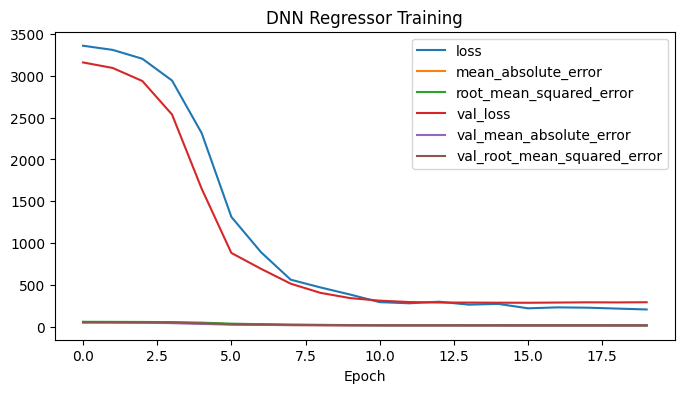

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Regressor: {'RMSE': 15.95716847018723, 'MAE': 13.2393217086792, 'R2': 0.7196623682975769}


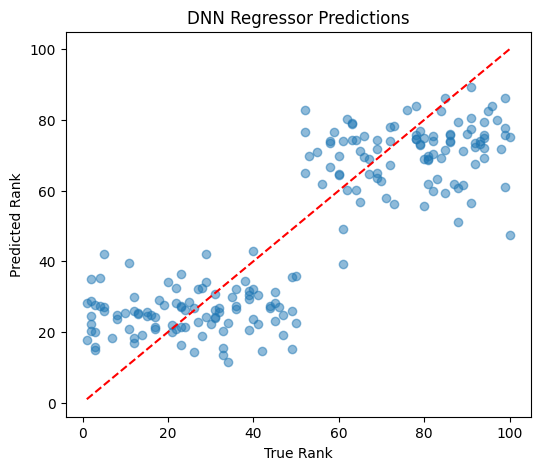

Epoch 1/20
10/10 - 2s - 246ms/step - accuracy: 0.5884 - loss: 1.2453 - val_accuracy: 0.8875 - val_loss: 1.0243
Epoch 2/20
10/10 - 0s - 35ms/step - accuracy: 0.8748 - loss: 0.8358 - val_accuracy: 0.9000 - val_loss: 0.5357
Epoch 3/20
10/10 - 0s - 15ms/step - accuracy: 0.8889 - loss: 0.4714 - val_accuracy: 0.9000 - val_loss: 0.3062
Epoch 4/20
10/10 - 0s - 8ms/step - accuracy: 0.9014 - loss: 0.3221 - val_accuracy: 0.9000 - val_loss: 0.2739
Epoch 5/20
10/10 - 0s - 8ms/step - accuracy: 0.8920 - loss: 0.2788 - val_accuracy: 0.8813 - val_loss: 0.2732
Epoch 6/20
10/10 - 0s - 15ms/step - accuracy: 0.8889 - loss: 0.2682 - val_accuracy: 0.8813 - val_loss: 0.2720
Epoch 7/20
10/10 - 0s - 8ms/step - accuracy: 0.8998 - loss: 0.2719 - val_accuracy: 0.8938 - val_loss: 0.2738
Epoch 8/20
10/10 - 0s - 8ms/step - accuracy: 0.9014 - loss: 0.2499 - val_accuracy: 0.8875 - val_loss: 0.2704
Epoch 9/20
10/10 - 0s - 13ms/step - accuracy: 0.9108 - loss: 0.2366 - val_accuracy: 0.8875 - val_loss: 0.2783
Epoch 10/20
1

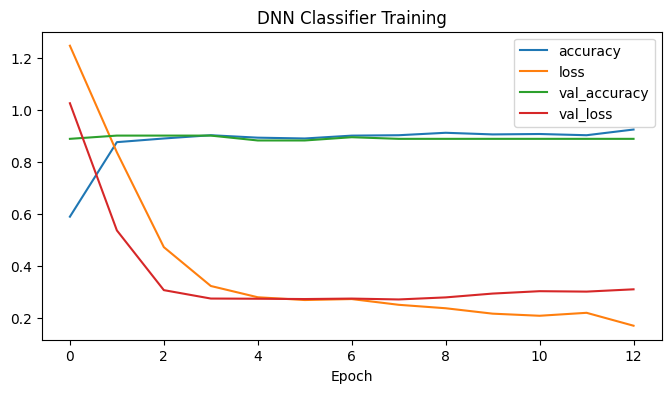

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Classifier Report:
               precision    recall  f1-score   support

       Top10       0.00      0.00      0.00        20
       Top50       0.80      0.97      0.88        80
      Top100       1.00      1.00      1.00       100

    accuracy                           0.89       200
   macro avg       0.60      0.66      0.63       200
weighted avg       0.82      0.89      0.85       200



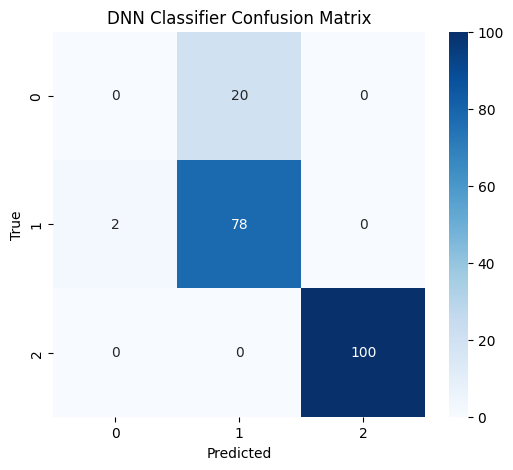

In [6]:
# ==============================================================
# Deep Learning for Amazon Bestsellers (2025) with Graph Outputs
# ==============================================================

import os, re, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    classification_report, confusion_matrix
)
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------
# 0) Repro, Paths, Setup
# -----------------------
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
try:
    gpus = tf.config.list_physical_devices("GPU")
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
except Exception:
    pass

CANDIDATE_PATHS = [
    "/mnt/data/extracted_data/Amazon_bestsellers_items_2025.csv",
    "/mnt/data/Amazon_bestsellers_items_2025.csv",
    "Amazon_bestsellers_items_2025.csv",
    "./Amazon_bestsellers_items_2025.csv"
]
DATA_PATH = next((p for p in CANDIDATE_PATHS if os.path.exists(p)), None)
if DATA_PATH is None:
    raise FileNotFoundError("Amazon_bestsellers_items_2025.csv not found.")

OUT_DIR = "deep_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------
# 1) Load + Clean Data
# -----------------------
df = pd.read_csv(DATA_PATH)
if "rank" not in df.columns:
    raise ValueError("Expected a 'rank' column in the dataset.")

def parse_price(x):
    if pd.isna(x): return np.nan
    x = re.sub(r"[^0-9.]", "", str(x))
    return float(x) if x else np.nan

df["price_num"] = df.get("product_price", pd.Series([np.nan]*len(df))).apply(parse_price)

def bucket_rank(r):
    try:
        r = float(r)
    except Exception:
        return "Others"
    if r <= 10: return "Top10"
    elif r <= 50: return "Top50"
    elif r <= 100: return "Top100"
    else: return "Others"

df["rank_bucket"] = df["rank"].apply(bucket_rank)

num_cols = [c for c in ["price_num","product_star_rating","product_num_ratings","page"] if c in df.columns]
cat_cols = [c for c in ["country"] if c in df.columns]
text_col = "product_title" if "product_title" in df.columns else None

for c in num_cols: df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32").fillna(df[c].median())
for c in cat_cols: df[c] = df[c].astype(str).fillna("NA")
if text_col: df[text_col] = df[text_col].astype(str).fillna("")

# -----------------------
# 2) Split
# -----------------------
can_strat = df["rank_bucket"].nunique() > 1 and df["rank_bucket"].value_counts().min() >= 2
if can_strat:
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["rank_bucket"], random_state=SEED)
    train_df, val_df  = train_test_split(train_df, test_size=0.2, stratify=train_df["rank_bucket"], random_state=SEED)
else:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)
    train_df, val_df  = train_test_split(train_df, test_size=0.2, random_state=SEED)

y_train_reg, y_val_reg, y_test_reg = train_df["rank"].astype("float32").values, val_df["rank"].astype("float32").values, test_df["rank"].astype("float32").values

class_names = ["Top10","Top50","Top100","Others"]
class_to_idx = {c:i for i,c in enumerate(class_names)}
y_train_cls = train_df["rank_bucket"].map(class_to_idx).fillna(class_to_idx["Others"]).astype("int32").values
y_val_cls   = val_df["rank_bucket"].map(class_to_idx).fillna(class_to_idx["Others"]).astype("int32").values
y_test_cls  = test_df["rank_bucket"].map(class_to_idx).fillna(class_to_idx["Others"]).astype("int32").values

# -----------------------
# 3) Preprocessing Layers
# -----------------------
if num_cols:
    norm_layer = layers.Normalization(dtype=tf.float32)
    norm_layer.adapt(train_df[num_cols].astype("float32").values)
else:
    norm_layer = None

if "country" in cat_cols:
    country_lookup = layers.StringLookup(output_mode="int", name="country_idx")
    country_lookup.adapt(train_df["country"].astype(str).values)
    country_vocab_size = max(len(country_lookup.get_vocabulary()), 2)
    country_embed_dim = max(4, min(16, country_vocab_size // 2))
else:
    country_lookup = None
    country_vocab_size, country_embed_dim = 0, 0

if text_col:
    text_vec = layers.TextVectorization(max_tokens=15000, output_mode="int", output_sequence_length=24, name="title_vec")
    text_vec.adapt(train_df[text_col].astype(str).values)
    text_vocab_size = max(len(text_vec.get_vocabulary()), 2)
    text_embed_dim = 64
else:
    text_vec, text_vocab_size, text_embed_dim = None, 0, 0

# -----------------------
# 4) tf.data Datasets
# -----------------------
def make_xy_dict(frame):
    feats = {}
    if num_cols: feats["num"] = frame[num_cols].astype("float32").values
    if "country" in cat_cols: feats["country"] = frame["country"].astype(str).values
    if text_col: feats["title"] = frame[text_col].astype(str).values
    return feats

def make_ds(frame, y=None, batch=64, shuffle=False):
    x = make_xy_dict(frame)
    ds = tf.data.Dataset.from_tensor_slices((x, y)) if y is not None else tf.data.Dataset.from_tensor_slices(x)
    if shuffle: ds = ds.shuffle(buffer_size=len(frame), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

train_ds_reg = make_ds(train_df, y_train_reg, shuffle=True)
val_ds_reg   = make_ds(val_df,   y_val_reg)
test_ds_reg  = make_ds(test_df,  y_test_reg)

train_ds_cls = make_ds(train_df, y_train_cls, shuffle=True)
val_ds_cls   = make_ds(val_df,   y_val_cls)
test_ds_cls  = make_ds(test_df,  y_test_cls)

# -----------------------
# 5) Inputs & Encoder
# -----------------------
def build_inputs():
    inputs = {}
    if num_cols: inputs["num"] = keras.Input(shape=(len(num_cols),), dtype=tf.float32, name="num")
    if "country" in cat_cols: inputs["country"] = keras.Input(shape=(), dtype=tf.string, name="country")
    if text_col: inputs["title"] = keras.Input(shape=(), dtype=tf.string, name="title")
    return inputs

def encode_inputs(inputs):
    parts = []
    if "num" in inputs and norm_layer is not None: parts.append(norm_layer(inputs["num"]))
    if "country" in inputs and country_lookup is not None:
        idx = country_lookup(inputs["country"])
        cemb = layers.Embedding(country_vocab_size, country_embed_dim)(idx)
        parts.append(cemb)
    if "title" in inputs and text_vec is not None:
        toks = text_vec(inputs["title"])
        temb = layers.Embedding(text_vocab_size, text_embed_dim, mask_zero=True)(toks)
        parts.append(layers.GlobalAveragePooling1D()(temb))
    parts = [layers.Flatten()(p) if len(p.shape)>2 else p for p in parts]
    return parts[0] if len(parts)==1 else layers.Concatenate()(parts)

# -----------------------
# 6) Models
# -----------------------
def build_dnn_regressor():
    inputs = build_inputs()
    x = encode_inputs(inputs)
    for h in [128,64,32]:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(0.2)(x)
    out = layers.Dense(1)(x)
    model = keras.Model(inputs, out)
    model.compile(optimizer="adam", loss="mse", metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError()])
    return model

def build_dnn_classifier():
    inputs = build_inputs()
    x = encode_inputs(inputs)
    for h in [256,128,64]:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(0.3)(x)
    out = layers.Dense(len(class_names), activation="softmax")(x)
    model = keras.Model(inputs, out)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# -----------------------
# 7) Training + Graphs
# -----------------------
def plot_history(history, title):
    plt.figure(figsize=(8,4))
    for k,v in history.history.items():
        plt.plot(v, label=k)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_confusion(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

def plot_regression(y_true, y_pred, title):
    plt.figure(figsize=(6,5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
    plt.title(title)
    plt.xlabel("True Rank")
    plt.ylabel("Predicted Rank")
    plt.show()

def run_all():
    early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # --- Regressor
    reg = build_dnn_regressor()
    hist = reg.fit(train_ds_reg, validation_data=val_ds_reg, epochs=20, callbacks=[early], verbose=2)
    plot_history(hist, "DNN Regressor Training")
    y_pred = reg.predict(test_ds_reg).ravel()
    print("Regressor:", {
        "RMSE": mean_squared_error(y_test_reg,y_pred)**0.5, # Removed squared=False
        "MAE": mean_absolute_error(y_test_reg,y_pred),
        "R2": r2_score(y_test_reg,y_pred)
    })
    plot_regression(y_test_reg, y_pred, "DNN Regressor Predictions")

    # --- Classifier
    clf = build_dnn_classifier()
    hist = clf.fit(train_ds_cls, validation_data=val_ds_cls, epochs=20, callbacks=[early], verbose=2)
    plot_history(hist, "DNN Classifier Training")
    y_hat = np.argmax(clf.predict(test_ds_cls), axis=1)
    # Get unique labels from y_test_cls for the classification report and confusion matrix
    test_labels = sorted(np.unique(y_test_cls))
    target_names_subset = [class_names[i] for i in test_labels]
    print("Classifier Report:\n", classification_report(y_test_cls, y_hat, labels=test_labels, target_names=target_names_subset))
    plot_confusion(y_test_cls, y_hat, "DNN Classifier Confusion Matrix", labels=test_labels)

if __name__ == "__main__":
    run_all()


[Random Forest] Regression:
  RMSE: 15.167367930850693
  MAE : 12.909131726190475
  R²  : 0.7467262471274512


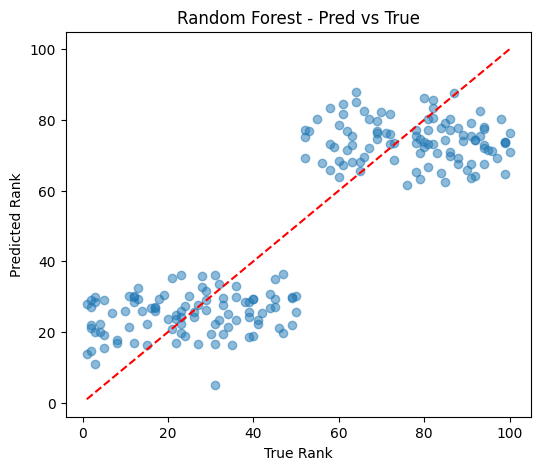

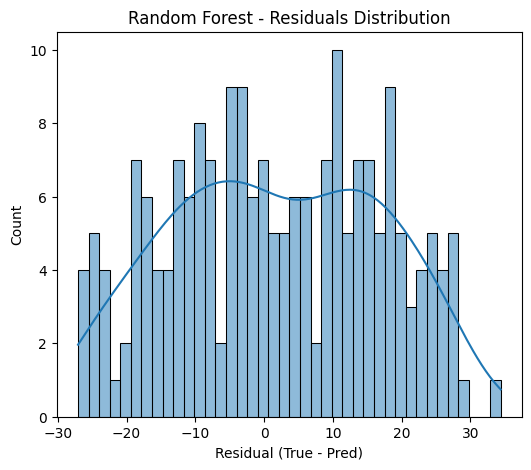


[Gradient Boosting] Regression:
  RMSE: 14.864503901903985
  MAE : 12.908930972770696
  R²  : 0.7567400684670769


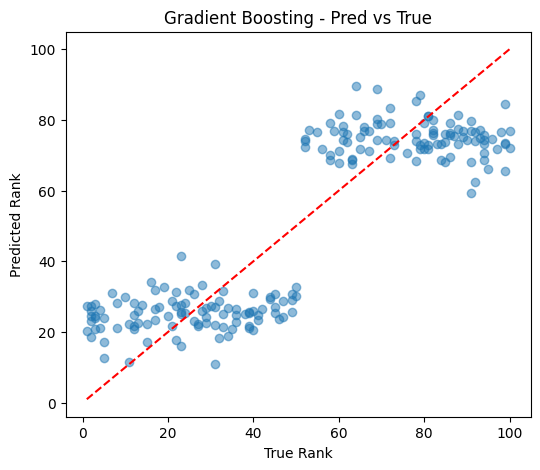

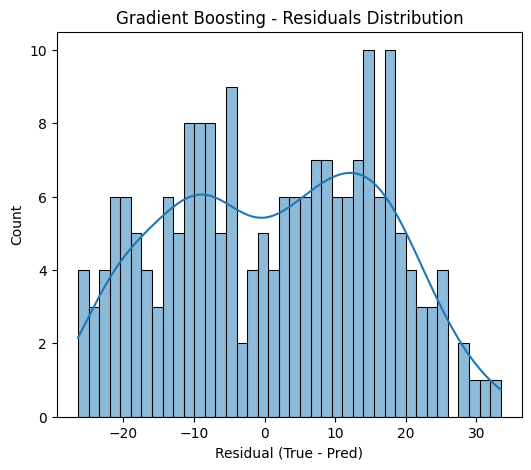


[XGBoost] Regression:
  RMSE: 16.198526875898892
  MAE : 13.680196762084961
  R²  : 0.7111178636550903


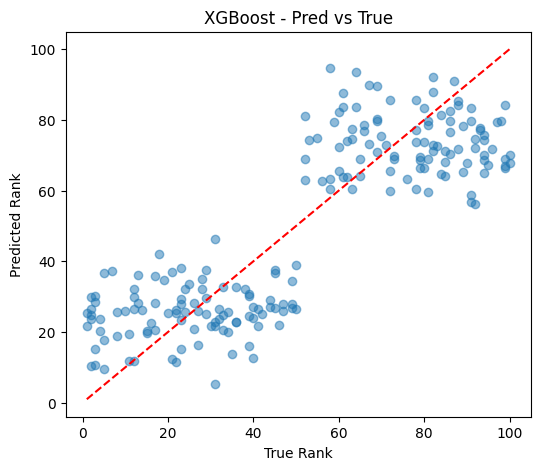

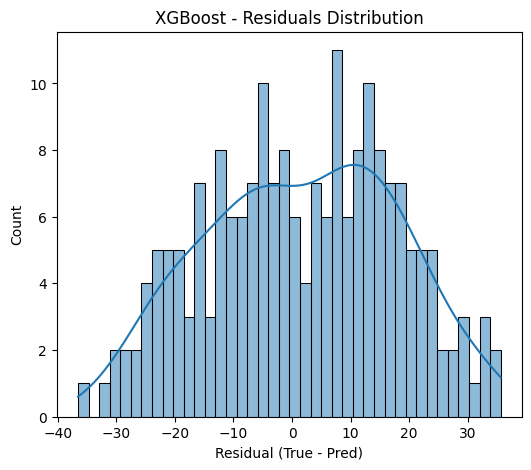


[Stacking Ensemble] Regression:
  RMSE: 14.853731690762622
  MAE : 12.768315264299337
  R²  : 0.7570925185523616


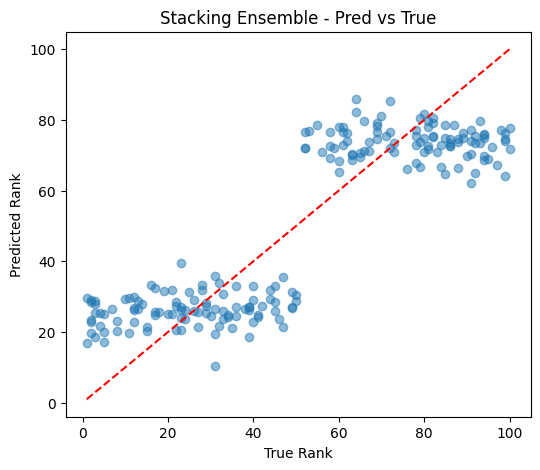

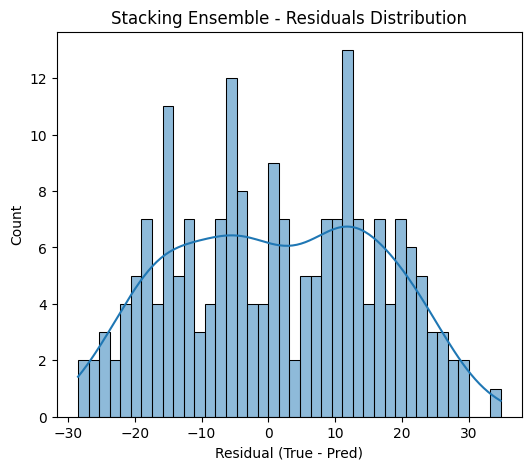


[Random Forest] Classification:
              precision    recall  f1-score   support

       Top10     0.5000    0.2000    0.2857        20
      Top100     1.0000    1.0000    1.0000       100
       Top50     0.8261    0.9500    0.8837        80

    accuracy                         0.9000       200
   macro avg     0.7754    0.7167    0.7231       200
weighted avg     0.8804    0.9000    0.8821       200



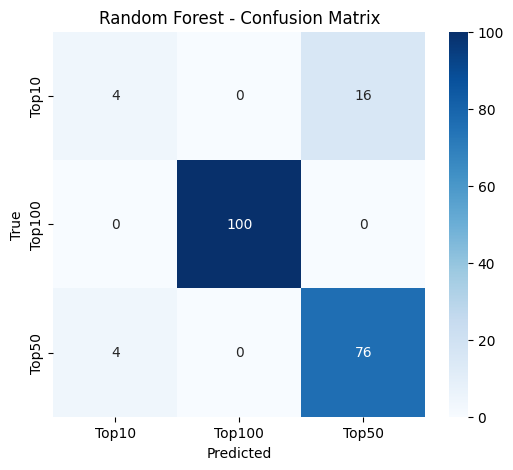

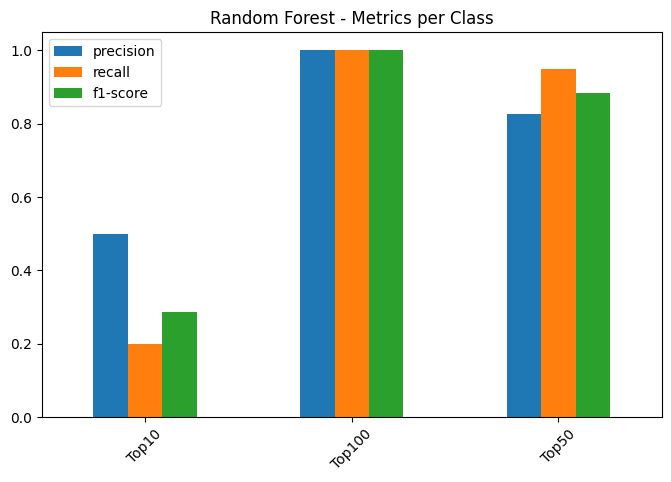


[Gradient Boosting] Classification:
              precision    recall  f1-score   support

       Top10     0.4000    0.2000    0.2667        20
      Top100     1.0000    1.0000    1.0000       100
       Top50     0.8222    0.9250    0.8706        80

    accuracy                         0.8900       200
   macro avg     0.7407    0.7083    0.7124       200
weighted avg     0.8689    0.8900    0.8749       200



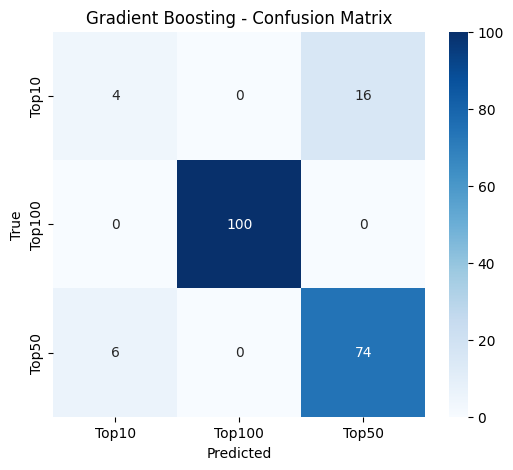

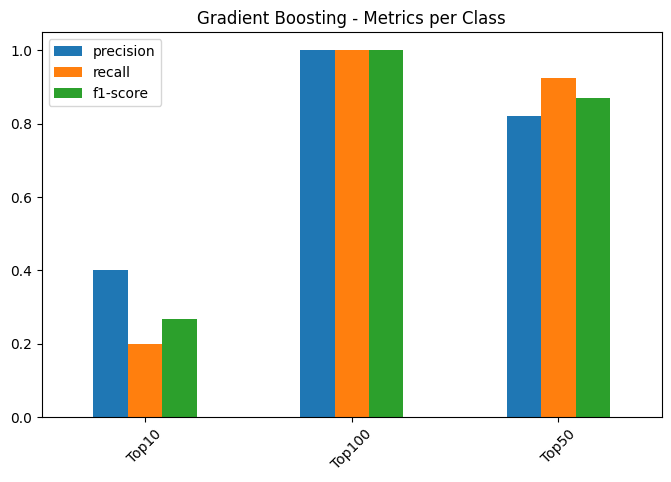


[XGBoost] Classification:
              precision    recall  f1-score   support

       Top10     0.4545    0.2500    0.3226        20
      Top100     1.0000    1.0000    1.0000       100
       Top50     0.8315    0.9250    0.8757        80

    accuracy                         0.8950       200
   macro avg     0.7620    0.7250    0.7328       200
weighted avg     0.8780    0.8950    0.8826       200



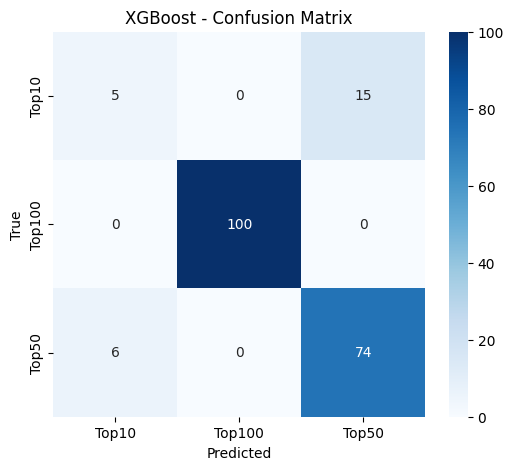

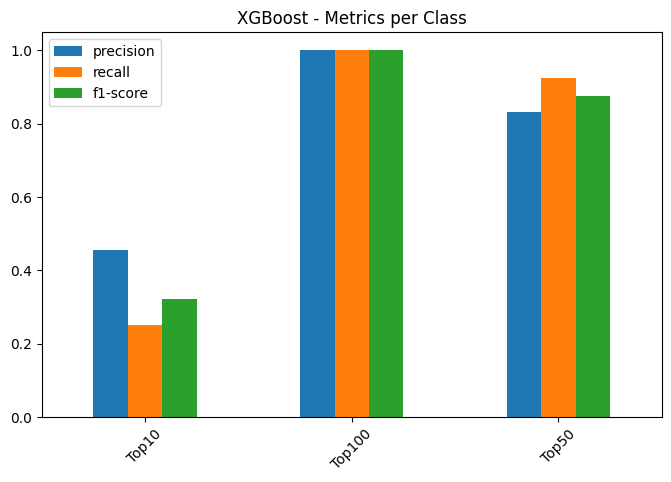


[Stacking Ensemble] Classification:
              precision    recall  f1-score   support

       Top10     0.5000    0.0500    0.0909        20
      Top100     1.0000    1.0000    1.0000       100
       Top50     0.8061    0.9875    0.8876        80

    accuracy                         0.9000       200
   macro avg     0.7687    0.6792    0.6595       200
weighted avg     0.8724    0.9000    0.8641       200



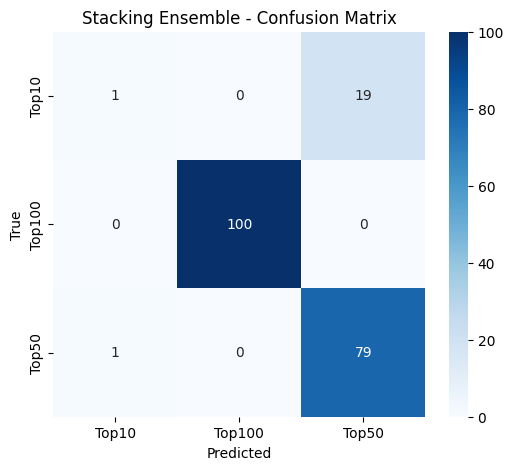

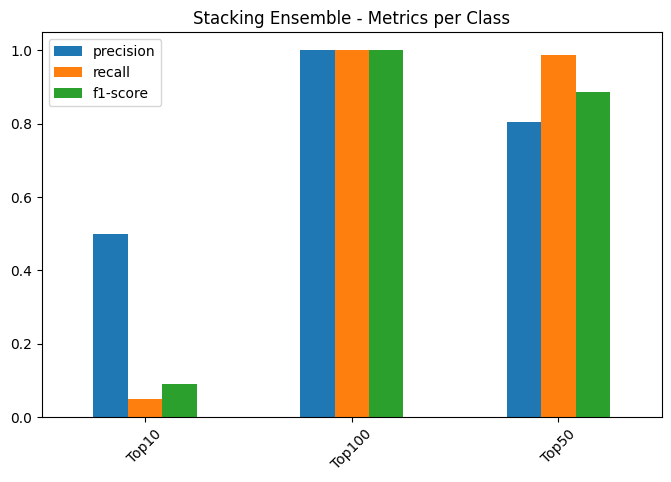

In [10]:
# ==============================================================
# Ensemble Learning for Amazon Bestseller Rankings (2025)
# with Graph Outputs
# ==============================================================

import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    classification_report, confusion_matrix
)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import StackingRegressor, StackingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb

# -----------------------
# 1) Load + Clean Data
# -----------------------
DATA_PATH = "Amazon_bestsellers_items_2025.csv"
if not os.path.exists(DATA_PATH):
    for alt_path in ["/mnt/data/Amazon_bestsellers_items_2025.csv",
                     "/mnt/data/extracted_data/Amazon_bestsellers_items_2025.csv",
                     "./Amazon_bestsellers_items_2025.csv"]:
        if os.path.exists(alt_path):
            DATA_PATH = alt_path
            break

df = pd.read_csv(DATA_PATH)

# Price clean
def parse_price(x):
    if pd.isna(x): return np.nan
    x = re.sub(r"[^0-9.]", "", str(x))
    try: return float(x) if x else np.nan
    except: return np.nan

df["price_num"] = df.get("product_price", pd.Series([np.nan]*len(df))).apply(parse_price)

# Rank buckets
def bucket_rank(r):
    if r <= 10: return "Top10"
    elif r <= 50: return "Top50"
    elif r <= 100: return "Top100"
    else: return "Others"
df["rank_bucket"] = df["rank"].apply(bucket_rank)

# Features
num_cols = [c for c in ["price_num","product_star_rating","product_num_ratings","page"] if c in df.columns]
cat_cols = [c for c in ["country"] if c in df.columns]

for c in num_cols: df[c] = df[c].fillna(df[c].median())
for c in cat_cols: df[c] = df[c].fillna("NA")

# Encode categorical
for c in cat_cols:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])

X = df[num_cols + cat_cols]
y_reg = df["rank"]
y_cls = df["rank_bucket"]

# -----------------------
# 2) Split Data
# -----------------------
X_train, X_test, y_train_reg, y_test_reg, y_train_cls, y_test_cls = train_test_split(
    X, y_reg, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Encode classification labels
le_cls = LabelEncoder()
y_train_cls = le_cls.fit_transform(y_train_cls)
y_test_cls  = le_cls.transform(y_test_cls)
class_names = le_cls.classes_

# -----------------------
# 3) Ensemble Models
# -----------------------
# Regressors
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
gb_reg = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_reg = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)

stack_reg = StackingRegressor(
    estimators=[("rf", rf_reg), ("gb", gb_reg), ("xgb", xgb_reg)],
    final_estimator=LinearRegression()
)

# Classifiers
rf_cls = RandomForestClassifier(n_estimators=200, random_state=42)
gb_cls = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_cls = xgb.XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=6,
                            use_label_encoder=False, eval_metric="mlogloss", random_state=42)

stack_cls = StackingClassifier(
    estimators=[("rf", rf_cls), ("gb", gb_cls), ("xgb", xgb_cls)],
    final_estimator=LogisticRegression(max_iter=1000)
)

# -----------------------
# 4) Train + Evaluate with Graphs
# -----------------------
def plot_regression_results(y_true, y_pred, title):
    plt.figure(figsize=(6,5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()], "r--")
    plt.title(title + " - Pred vs True")
    plt.xlabel("True Rank")
    plt.ylabel("Predicted Rank")
    plt.show()

    residuals = y_true - y_pred
    plt.figure(figsize=(6,5))
    sns.histplot(residuals, bins=40, kde=True)
    plt.title(title + " - Residuals Distribution")
    plt.xlabel("Residual (True - Pred)")
    plt.show()

def plot_classification_results(y_true, y_pred, title):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title + " - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification report bar chart
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3,:]  # exclude accuracy/support
    report_df[["precision","recall","f1-score"]].plot(kind="bar", figsize=(8,5))
    plt.title(title + " - Metrics per Class")
    plt.xticks(rotation=45)
    plt.show()

def eval_reg(name, model):
    model.fit(X_train, y_train_reg)
    y_pred = model.predict(X_test)
    print(f"\n[{name}] Regression:")
    # Calculate RMSE by taking the square root of MSE
    print("  RMSE:", mean_squared_error(y_test_reg, y_pred)**0.5)
    print("  MAE :", mean_absolute_error(y_test_reg, y_pred))
    print("  R²  :", r2_score(y_test_reg, y_pred))
    plot_regression_results(y_test_reg, y_pred, name)

def eval_cls(name, model):
    model.fit(X_train, y_train_cls)
    y_pred = model.predict(X_test)
    print(f"\n[{name}] Classification:")
    print(classification_report(y_test_cls, y_pred, target_names=class_names, digits=4, zero_division=0))
    plot_classification_results(y_test_cls, y_pred, name)

# -----------------------
# 5) Run Evaluations
# -----------------------
# Regression
for name, model in [("Random Forest", rf_reg), ("Gradient Boosting", gb_reg),
                    ("XGBoost", xgb_reg), ("Stacking Ensemble", stack_reg)]:
    eval_reg(name, model)

# Classification
for name, model in [("Random Forest", rf_cls), ("Gradient Boosting", gb_cls),
                    ("XGBoost", xgb_cls), ("Stacking Ensemble", stack_cls)]:
    eval_cls(name, model)


=== Classification Results ===
Accuracy: 0.91
F1-macro: 0.7647058823529411
              precision    recall  f1-score   support

       Top10       0.60      0.30      0.40        20
      Top100       1.00      1.00      1.00       100
       Top50       0.84      0.95      0.89        80

    accuracy                           0.91       200
   macro avg       0.81      0.75      0.76       200
weighted avg       0.90      0.91      0.90       200



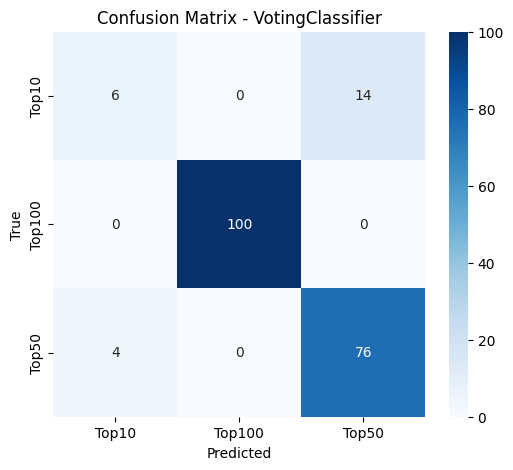

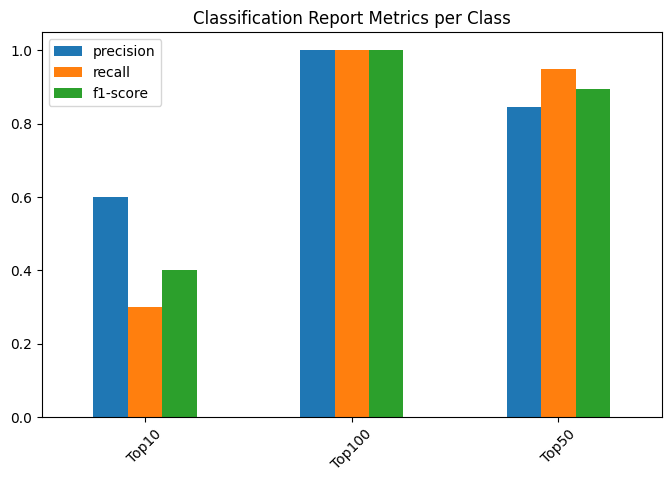


=== Regression Results ===
RMSE: 14.021550393574085
MAE: 11.951209824322248
R2: 0.7835478939264251


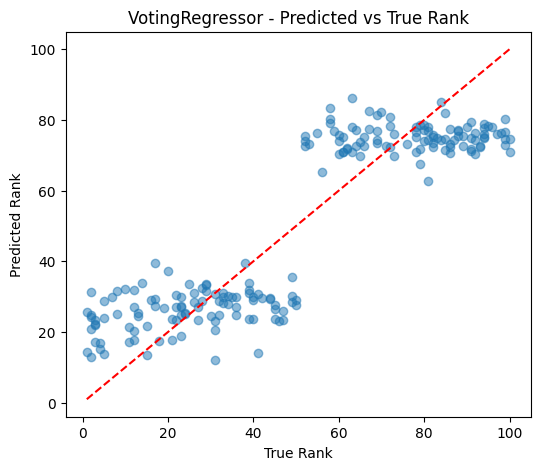

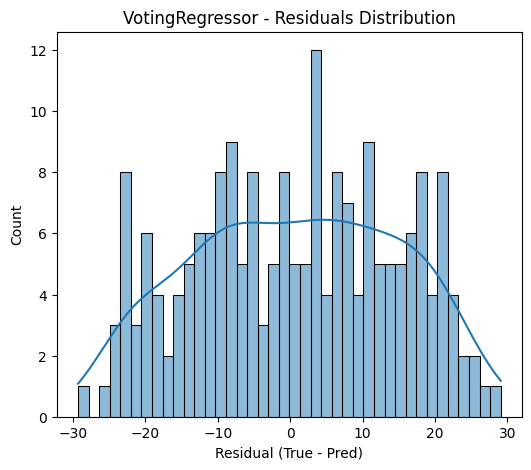


✅ Finished. Results and models saved in fast_outputs


In [11]:
# ==============================================================
# Amazon Bestsellers 2025 — Fast Ensemble with Graph Outputs
# ==============================================================

import os, re, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import (
    HistGradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier,
    HistGradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
)
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)
import joblib

# -----------------------
# 0) Load Data
# -----------------------
CANDIDATE_PATHS = [
    "/mnt/data/extracted_data/Amazon_bestsellers_items_2025.csv",
    "/mnt/data/Amazon_bestsellers_items_2025.csv",
    "Amazon_bestsellers_items_2025.csv",
    "./Amazon_bestsellers_items_2025.csv"
]
DATA_PATH = next((p for p in CANDIDATE_PATHS if os.path.exists(p)), None)
if DATA_PATH is None:
    raise FileNotFoundError("Amazon_bestsellers_items_2025.csv not found.")

OUT_DIR = "fast_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH)

# -----------------------
# 1) Clean + Features
# -----------------------
def parse_price(x):
    if pd.isna(x): return np.nan
    x = re.sub(r"[^0-9.]", "", str(x))
    try: return float(x) if x else np.nan
    except: return np.nan

df["price_num"] = df.get("product_price", pd.Series([np.nan]*len(df))).apply(parse_price)

def bucket_rank(r):
    try: r = float(r)
    except: return "Others"
    if r <= 10: return "Top10"
    elif r <= 50: return "Top50"
    elif r <= 100: return "Top100"
    else: return "Others"

df["rank_bucket"] = df["rank"].apply(bucket_rank)

num_cols = [c for c in ["price_num","product_star_rating","product_num_ratings","page"] if c in df.columns]
cat_cols = [c for c in ["country"] if c in df.columns]
text_col = "product_title" if "product_title" in df.columns else None

# -----------------------
# 2) Split
# -----------------------
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["rank_bucket"])

y_train_cls = train_df["rank_bucket"]
y_test_cls  = test_df["rank_bucket"]

y_train_reg = train_df["rank"]
y_test_reg  = test_df["rank"]

# -----------------------
# 3) Preprocessing
# -----------------------
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe())
])

text_pipe = Pipeline([("tfidf", TfidfVectorizer(max_features=5000, stop_words="english")),
                      ("svd", TruncatedSVD(n_components=50, random_state=42))]) if text_col else "drop"

transformers = []
if num_cols: transformers.append(("num", num_pipe, num_cols))
if cat_cols: transformers.append(("cat", cat_pipe, cat_cols))
if text_col: transformers.append(("txt", text_pipe, text_col))

pre = ColumnTransformer(transformers, remainder="drop")

# -----------------------
# 4) Classifier Ensemble
# -----------------------
clf_hgb = Pipeline([("pre", pre), ("clf", HistGradientBoostingClassifier(random_state=42))])
clf_et  = Pipeline([("pre", pre), ("clf", ExtraTreesClassifier(n_estimators=300, random_state=42, n_jobs=-1))])
clf_lin = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=500, random_state=42))])

voting_cls = VotingClassifier(
    estimators=[("hgb", clf_hgb), ("et", clf_et), ("lin", clf_lin)],
    voting="soft", n_jobs=-1
)
voting_cls.fit(train_df, y_train_cls)

pred_cls = voting_cls.predict(test_df)
print("\n=== Classification Results ===")
print("Accuracy:", accuracy_score(y_test_cls, pred_cls))
print("F1-macro:", f1_score(y_test_cls, pred_cls, average="macro"))
print(classification_report(y_test_cls, pred_cls))

# --- Graphs: Classification ---
cm = confusion_matrix(y_test_cls, pred_cls, labels=voting_cls.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=voting_cls.classes_, yticklabels=voting_cls.classes_)
plt.title("Confusion Matrix - VotingClassifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

report = classification_report(y_test_cls, pred_cls, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).T.iloc[:-3,:]  # drop accuracy/support/avg
report_df[["precision","recall","f1-score"]].plot(kind="bar", figsize=(8,5))
plt.title("Classification Report Metrics per Class")
plt.xticks(rotation=45)
plt.show()

joblib.dump(voting_cls, os.path.join(OUT_DIR, "voting_classifier.joblib"))

# -----------------------
# 5) Regressor Ensemble
# -----------------------
reg_hgb = Pipeline([("pre", pre), ("reg", HistGradientBoostingRegressor(random_state=42))])
reg_et  = Pipeline([("pre", pre), ("reg", ExtraTreesRegressor(n_estimators=300, random_state=42, n_jobs=-1))])
reg_lin = Pipeline([("pre", pre), ("reg", RidgeCV(alphas=[0.1, 1.0, 10.0]))])

voting_reg = VotingRegressor(
    estimators=[("hgb", reg_hgb), ("et", reg_et), ("lin", reg_lin)], n_jobs=-1
)
voting_reg.fit(train_df, y_train_reg)

pred_reg = voting_reg.predict(test_df)
print("\n=== Regression Results ===")
# Calculate RMSE by taking the square root of MSE
print("RMSE:", mean_squared_error(y_test_reg, pred_reg)**0.5)
print("MAE:", mean_absolute_error(y_test_reg, pred_reg))
print("R2:", r2_score(y_test_reg, pred_reg))

# --- Graphs: Regression ---
plt.figure(figsize=(6,5))
plt.scatter(y_test_reg, pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], "r--")
plt.title("VotingRegressor - Predicted vs True Rank")
plt.xlabel("True Rank")
plt.ylabel("Predicted Rank")
plt.show()

residuals = y_test_reg - pred_reg
plt.figure(figsize=(6,5))
sns.histplot(residuals, bins=40, kde=True)
plt.title("VotingRegressor - Residuals Distribution")
plt.xlabel("Residual (True - Pred)")
plt.show()

joblib.dump(voting_reg, os.path.join(OUT_DIR, "voting_regressor.joblib"))

print(f"\n✅ Finished. Results and models saved in {OUT_DIR}")